In [1]:
from scipy.optimize import nnls
import numpy as np

In [2]:
def power_law_nl(x, a = 1, b = 2):
    return a * x**b

def power_law_inv(y, a = 1, b = 2):
    return (y / a)**(1/b)

In [3]:
#load data (.mat)
import scipy.io as sio
data = sio.loadmat('../../data/Data_cell_types_small_size.mat')

In [4]:
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'pyr', 'pv', 'sst', 'vip', 'contrast'])

In [5]:
#extract mean activity per cell type
som = data['sst']
som_act = np.mean(som, axis =0)

pv = data['pv']
pv_act = np.mean(pv, axis =0)

vip = data['vip']
vip_act = np.mean(vip, axis =0)

e = data['pyr']
e_act = np.mean(e, axis =0)

In [6]:
som_act

array([0.10236657, 0.12339172, 0.1086949 , 0.15047143, 0.26108373,
       0.55200543])

# fit som

In [6]:
# we use negative values to indicate inhibition (and then use non negative least squares)
A = np.concatenate((e_act[:,np.newaxis], -1*pv_act[:,np.newaxis], -1*som_act[:,np.newaxis], -1*vip_act[:,np.newaxis]), axis = 1)
A = np.concatenate((A, np.zeros((A.shape[0],1))), axis = 1)
A = np.concatenate((A, np.ones((A.shape[0],1))), axis = 1)

y = power_law_inv(som_act)


In [7]:
x_som = nnls(A, y)

In [8]:
x_som

(array([0.90247262, 0.        , 0.        , 0.51539458, 0.        ,
        0.3630127 ]),
 0.10177940318206172)

# fit pv

In [9]:
A = np.concatenate((e_act[:,np.newaxis], -1* pv_act[:,np.newaxis], -1*som_act[:,np.newaxis], -1*vip_act[:,np.newaxis]), axis = 1)
Is = data['contrast']#/100
A = np.concatenate((A, Is.T), axis=1) 
A = np.concatenate((A, np.ones((A.shape[0],1))), axis = 1)
y = power_law_inv(pv_act,)
x_pv = nnls(A, y)

In [10]:
x_pv

(array([0.6267717 , 0.        , 0.49034239, 0.        , 0.00383783,
        0.37665983]),
 0.024222399833674708)

# fit vip

In [11]:
A = np.concatenate((e_act[:,np.newaxis], -1*pv_act[:,np.newaxis], -1*som_act[:,np.newaxis], -1*vip_act[:,np.newaxis]), axis = 1)
A = np.concatenate((A, np.zeros((A.shape[0],1))), axis = 1)
A = np.concatenate((A, np.ones((A.shape[0],1))), axis = 1)
y = power_law_inv(vip_act)
x_vip = nnls(A, y)
x_vip

(array([0.61244814, 0.13455959, 0.52075599, 0.        , 0.        ,
        0.64538931]),
 0.10533766332518249)

# fit E

In [12]:
A = np.concatenate((e_act[:,np.newaxis], -1*pv_act[:,np.newaxis], -1*som_act[:,np.newaxis], -1*vip_act[:,np.newaxis]), axis = 1)
Is = data['contrast']#/100
A = np.concatenate((A, Is.T), axis=1) 
A = np.concatenate((A, np.ones((A.shape[0],1))), axis = 1)
y = power_law_inv(e_act)
x_e = nnls(A, y)
x_e

(array([0.85019137, 0.12046141, 0.32576243, 0.        , 0.00194141,
        0.34042947]),
 0.003432758054374423)

In [13]:
W = np.array([x_e[0][:], x_pv[0][:], x_som[0][:], x_vip[0][:]])
W.flatten()

array([0.85019137, 0.12046141, 0.32576243, 0.        , 0.00194141,
       0.34042947, 0.6267717 , 0.        , 0.49034239, 0.        ,
       0.00383783, 0.37665983, 0.90247262, 0.        , 0.        ,
       0.51539458, 0.        , 0.3630127 , 0.61244814, 0.13455959,
       0.52075599, 0.        , 0.        , 0.64538931])

# params

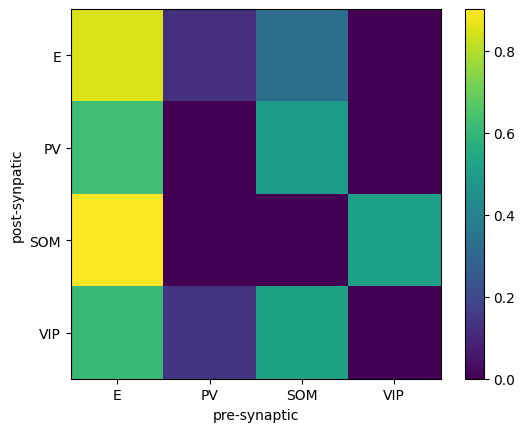

In [14]:
cells = ['E','PV', 'SOM', 'VIP']
W = np.array([x_e[0][:4], x_pv[0][:4], x_som[0][:4], x_vip[0][:4]])
#weight from pv to e
w_ep = x_e[0][1]

import matplotlib.pyplot as plt
plt.imshow(W)
plt.ylabel('post-synpatic')
plt.xlabel('pre-synaptic')
plt.xticks(np.arange(4), cells)
plt.yticks(np.arange(4), cells)
plt.colorbar()

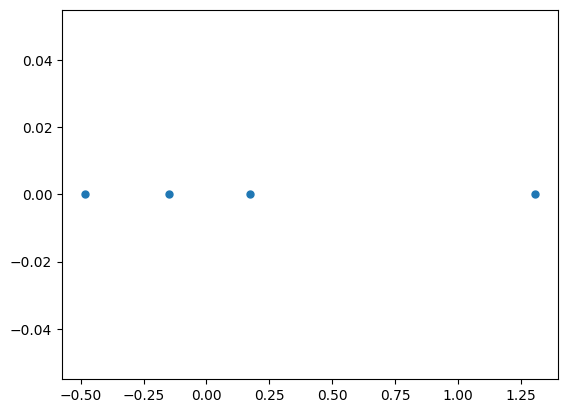

In [15]:
eigvals, eigvecs = np.linalg.eig(W)
plt.plot(np.real(eigvals), np.imag(eigvals), 'o', markersize=5)

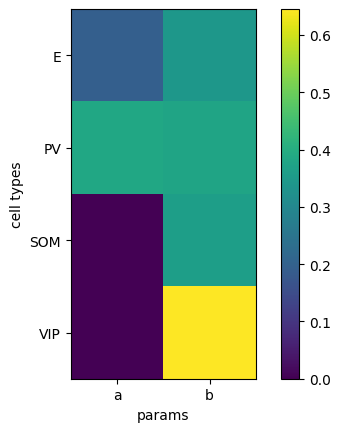

In [350]:

h = np.array([x_e[0][4:], x_pv[0][4:], x_som[0][4:], x_vip[0][4:]])

import matplotlib.pyplot as plt
plt.imshow(h)
plt.ylabel('cell types')
plt.xlabel('params')
plt.xticks(np.arange(2), ['a', 'b'])
plt.yticks(np.arange(4), cells)
plt.colorbar()

## simulations

In [225]:
#test simulator
import torch
i=0
max_it = 50000
wb = torch.tensor([x_e[0], x_pv[0], x_som[0], x_vip[0]], dtype=torch.float32).flatten()

delta_t = 0.001


r = torch.rand(4, 6)  # Initialize r with shape (4, 6)
I_values = data['contrast'][0][:]# Get the 6 different I values
rs = []

while i < max_it:
    
    for j, I in enumerate(I_values):
        A_1 = torch.tensor([r[0, j], -1 * r[1, j], -1 *r[2, j], -1 * r[3, j], I, 1])
        A_2 = torch.tensor([r[0, j], -1 * r[1, j], -1* r[2, j], -1 * r[3, j], 0, 1])

        r_delta = -r[:, j] + power_law_nl(torch.tensor([A_1 @ wb[0:6], A_1 @ wb[6:12], A_2 @ wb[12:18], A_2 @ wb[18:24]])) 
        r[:, j] = r[:, j] + delta_t * r_delta
    rs.append(r.numpy().copy())
    
    eps = torch.sum(torch.pow(r_delta, 2))
    if eps < 1e-6 or torch.isnan(eps):
        break
    
    i += 1

print(r,i)

KeyboardInterrupt: 

(26698, 4, 6)


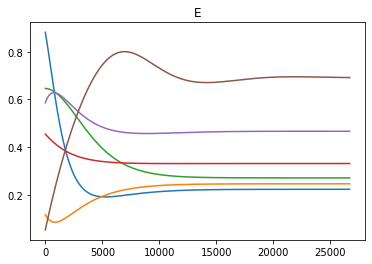

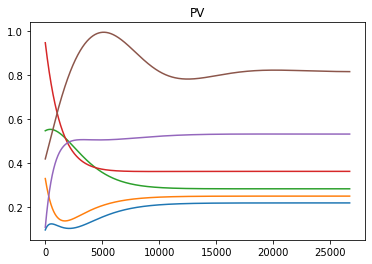

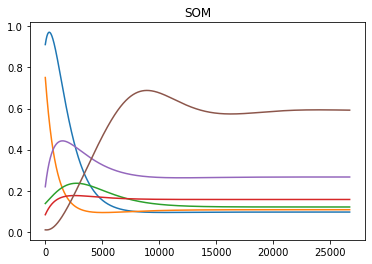

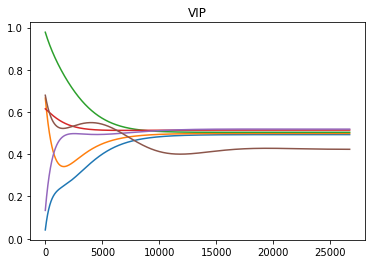

In [ ]:
rs = np.array(rs)
print(rs.shape)
for i, cell in enumerate(['E', 'PV', 'SOM', 'VIP']):
    plt.plot(rs[:,i])
    plt.title(cell)
    plt.show()

In [ ]:
#test simulator
import torch
i=0
max_it = 50000
wb = torch.tensor([x_e[0], x_pv[0], x_som[0], x_vip[0]], dtype=torch.float32).flatten()

delta_t = 0.001


r = torch.rand(4, 6)  # Initialize r with shape (4, 6)
I_values = data['contrast'][0][:]# Get the 6 different I values
rs = []

while i < max_it:
    
    for j, I in enumerate(I_values):
        # A_1 = torch.tensor([r[0, j], -1 * r[1, j], -1 *r[2, j], -1 * r[3, j], I, 1])
        # A_2 = torch.tensor([r[0, j], -1 * r[1, j], -1* r[2, j], -1 * r[3, j], 0, 1])

        A_1 = torch.tensor([r[0, j], -1 * 0, -1 *r[2, j], -1 * r[3, j], I, 1])
        A_2 = torch.tensor([r[0, j], -1 *0, -1* r[2, j], -1 * r[3, j], 0, 1])

        r_delta = -r[:, j] + power_law_nl(torch.tensor([A_1 @ wb[0:6], A_1 @ wb[6:12], A_2 @ wb[12:18], A_2 @ wb[18:24]])) 
        r[:, j] = r[:, j] + delta_t * r_delta
        r[1, j] =0
    rs.append(r.numpy().copy())
    
    eps = torch.sum(torch.pow(r_delta, 2))
    if eps < 1e-6 or torch.isnan(eps):
        break
    
    i += 1

print(r,i)

KeyboardInterrupt: 

(20721, 4, 6)


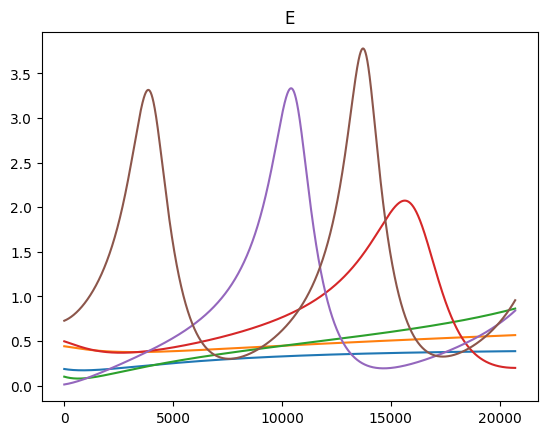

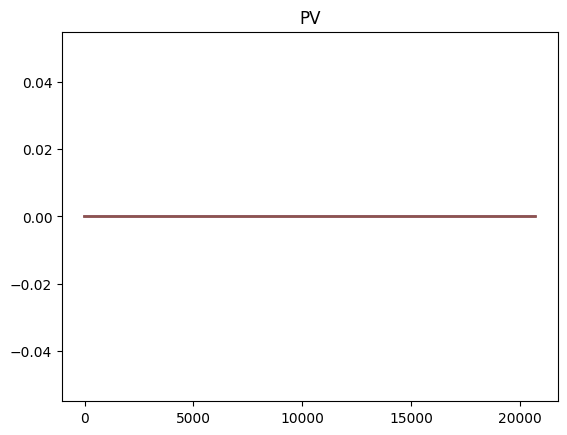

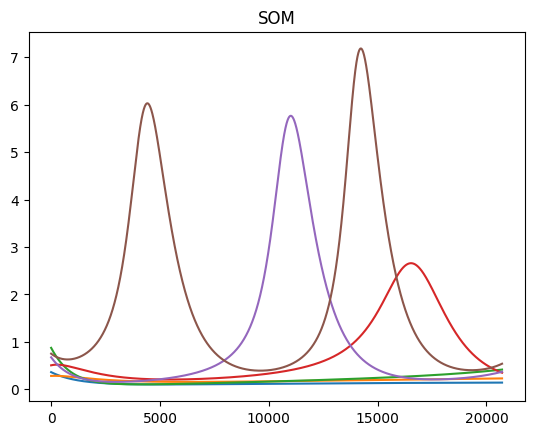

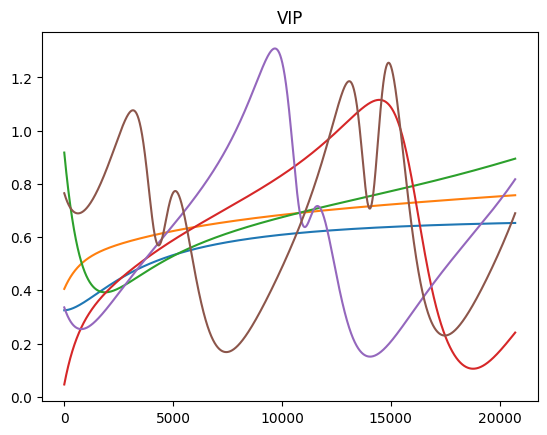

In [ ]:
rs = np.array(rs)
print(rs.shape)
for i, cell in enumerate(['E', 'PV', 'SOM', 'VIP']):
    plt.plot(rs[:,i])
    plt.title(cell)
    plt.show()

In [ ]:
#test simulator
import torch
i=0
max_it = 50000
wb = torch.tensor([x_e[0], x_pv[0], x_som[0], x_vip[0]], dtype=torch.float32).flatten()

delta_t = 0.001


r = torch.rand(4)  # Initialize r with shape (4, 6)
I_values =data['contrast'][0][0]# Get the 6 different I values
rs = []

while i < max_it:
    
  
    A_1 = torch.tensor([r[0], -1 * r[1], -1 *r[2], -1 * r[3], I, 1])
    A_2 = torch.tensor([r[0], -1 * r[1], -1* r[2], -1 * r[3], 0, 1])
    
    r_delta = -r + power_law_nl(torch.tensor([A_1 @ wb[0:6], A_1 @ wb[6:12], A_2 @ wb[12:18], A_2 @ wb[18:24]])) 
    r = r+ delta_t * r_delta
    rs.append(r.numpy())
    
    eps = torch.sum(torch.pow(r_delta, 2))
    if eps < 1e-6 or torch.isnan(eps):
        break
    
    i += 1

print(r,i)

IndexError: too many indices for tensor of dimension 1

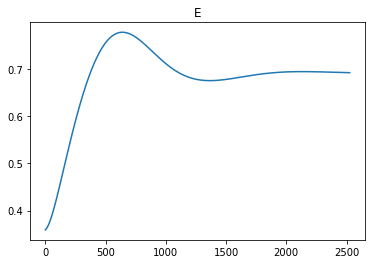

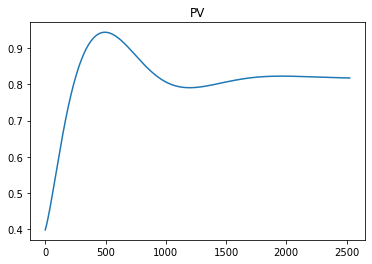

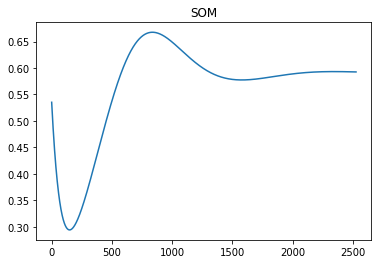

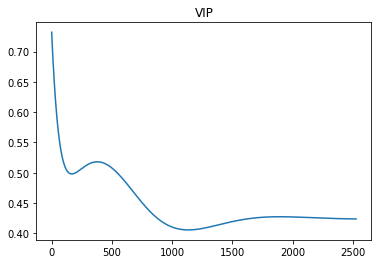

In [ ]:
rs = np.array(rs).squeeze()
for i, cell in enumerate(['E', 'PV', 'SOM', 'VIP']):
    plt.plot(rs[:,i])
    plt.title(cell)
    plt.show()

In [ ]:
#test simulator
import torch
i=0
max_it = 50000
wb = torch.tensor([x_e[0], x_pv[0], x_som[0], x_vip[0]], dtype=torch.float32).flatten()

delta_t = 0.001


r = torch.rand(4)  # Initialize r with shape (4, 6)
I_values =data['contrast'][0][1]# Get the 6 different I values
rs = []

while i < max_it:
    
  
    A_1 = torch.tensor([r[0], -1 * r[1], -1 *r[2], -1 * r[3], I, 1])
    A_2 = torch.tensor([r[0], -1 * r[1], -1* r[2], -1 * r[3], 0, 1])
    
    r_delta = -r + power_law_nl(torch.tensor([A_1 @ wb[0:6], A_1 @ wb[6:12], A_2 @ wb[12:18], A_2 @ wb[18:24]])) 
    r = r+ delta_t * r_delta
    #r[3]=0
    rs.append(r.numpy())
    
    eps = torch.sum(torch.pow(r_delta, 2))
    if eps < 1e-6 or torch.isnan(eps):
        break
    
    i += 1

print(r,i)

tensor([0.6913, 0.8165, 0.5918, 0.4234]) 26187


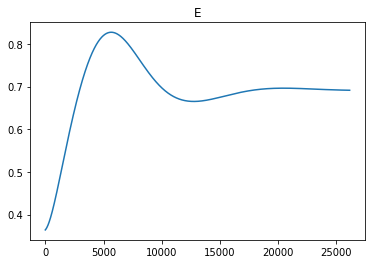

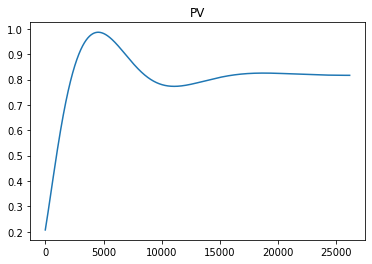

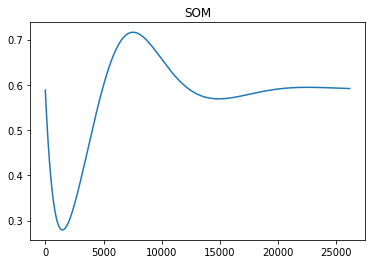

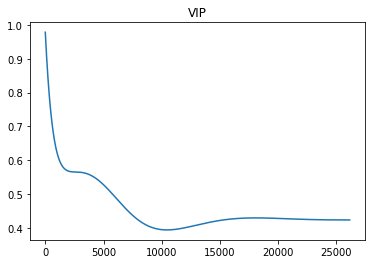

In [ ]:
rs = np.array(rs).squeeze()
for i, cell in enumerate(['E', 'PV', 'SOM', 'VIP']):
    plt.plot(rs[:,i][:-50])
    plt.title(cell)
    plt.show()

## Eigenvalues of Jacobian

In [27]:
x_e[0]

array([0.85019137, 0.12046141, 0.32576243, 0.        , 0.00194141,
       0.34042947])

### simulate rates

In [142]:
#test simulator
import torch
i=0
max_it = 50000
wb = torch.tensor([x_e[0], x_pv[0], x_som[0], x_vip[0]], dtype=torch.float32) 

# wb[1,:] = torch.tensor([0,0,0,0,0,0])
# wb[0,1] = 0
# wb[2,1] = 0
# wb[3,1] = 0
wb = wb.flatten()

delta_t = 0.001
tau = torch.tensor([1.0, 1.0, 1.0, 1.0]) 



r = torch.rand(4)  # Initialize r with shape (4, 6)
I_values =data['contrast'][0][0]/torch.tensor([100])# Get the 6 different I values
rs = []

while i < max_it:
    
  
    A_1 = torch.tensor([r[0], -1 * r[1], -1 *r[2], -1 * r[3], I_values, 1])
    A_2 = torch.tensor([r[0], -1 * r[1], -1* r[2], -1 * r[3], 0, 1])
    
    r_delta = -r + power_law_nl(torch.tensor([A_1 @ wb[0:6], A_1 @ wb[6:12], A_2 @ wb[12:18], A_2 @ wb[18:24]])) 
    r = r+ delta_t * r_delta/tau
    rs.append(r.numpy())
    
    eps = torch.sum(torch.pow(r_delta, 2))
    if eps < 1e-9 or torch.isnan(eps):
        break
    
    i += 1

print(r,i)

tensor([0.2228, 0.2201, 0.0961, 0.4931]) 21756


In [158]:
x_e[0][0]

0.850191373824937

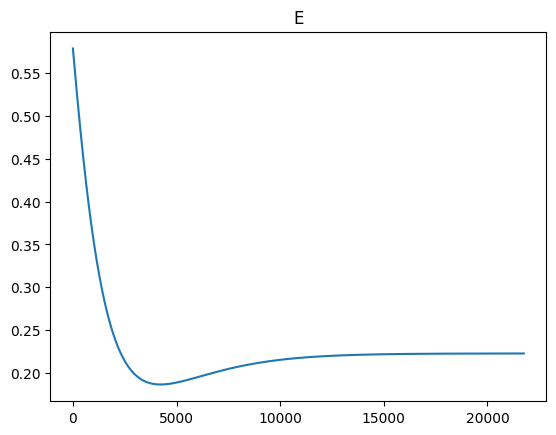

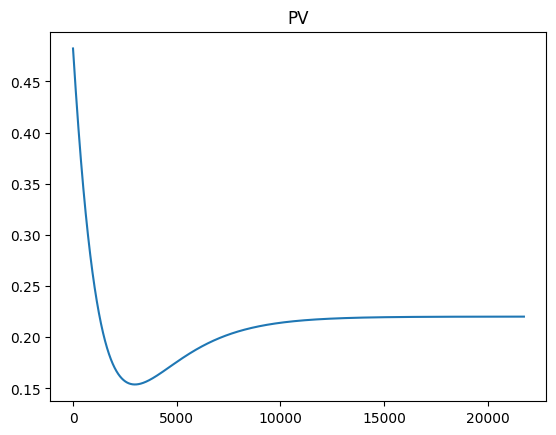

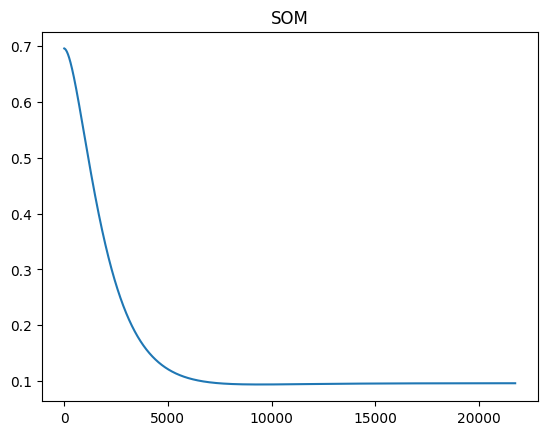

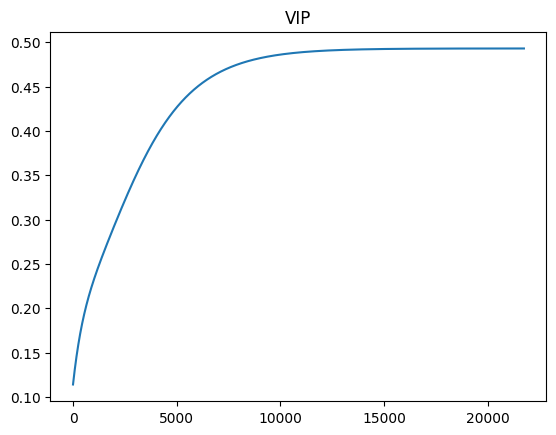

In [143]:
rs = np.array(rs).squeeze()
for i, cell in enumerate(['E', 'PV', 'SOM', 'VIP']):
    plt.plot(rs[:,i])
    plt.title(cell)
    plt.show()

### compute eigenvalues of jacobians

In [144]:
def get_jacobian(W, idx):
    W = np.delete(W, idx, 1)
    W = np.delete(W, idx, 0)
    phi_prime = np.diag(2 *np.delete(r,idx))
    print(W)
    J = (-np.eye(len(W))+ phi_prime @ W)/np.delete(tau,idx)
    return J

[[0.         0.49034239 0.        ]
 [0.         0.         0.51539458]
 [0.13455959 0.52075599 0.        ]]


Text(0.5, 1.0, 'without E')

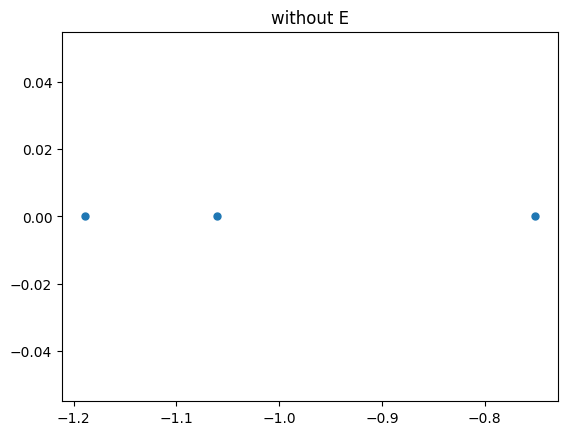

In [145]:
#no e

J = get_jacobian(W, 0)
eigvals, eigvecs = np.linalg.eig(J)
plt.plot(np.real(eigvals), np.imag(eigvals), 'o', markersize=5)
plt.title('without E')


[[0.85019137 0.32576243 0.        ]
 [0.90247262 0.         0.51539458]
 [0.61244814 0.52075599 0.        ]]


Text(0.5, 1.0, 'without PV')

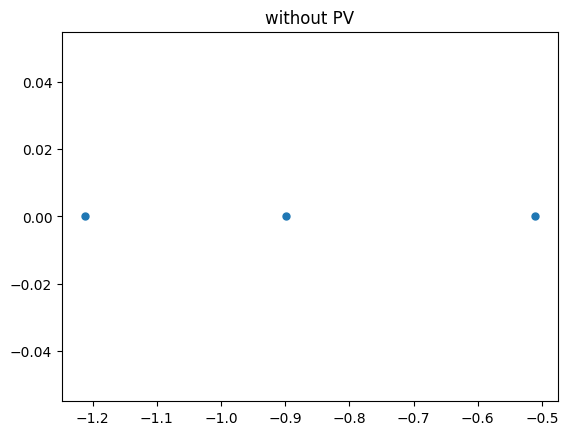

In [146]:
#no pv

J = get_jacobian(W, 1)
eigvals, eigvecs = np.linalg.eig(J)
plt.plot(np.real(eigvals), np.imag(eigvals), 'o', markersize=5)
plt.title('without PV')

[[0.85019137 0.12046141 0.        ]
 [0.6267717  0.         0.        ]
 [0.61244814 0.13455959 0.        ]]


Text(0.5, 1.0, 'without SOM')

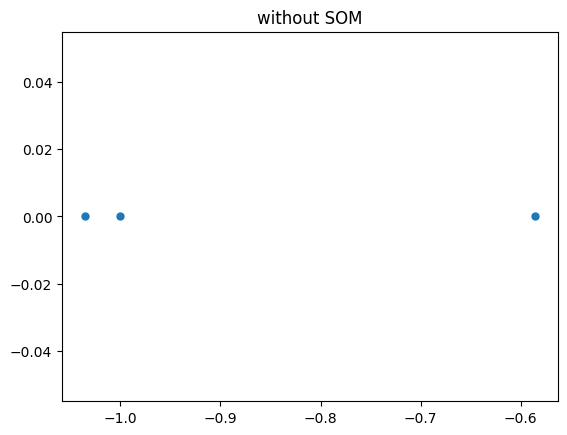

In [147]:

J = get_jacobian(W, 2)
eigvals, eigvecs = np.linalg.eig(J)
plt.plot(np.real(eigvals), np.imag(eigvals), 'o', markersize=5)
plt.title('without SOM')

[[0.85019137 0.12046141 0.32576243]
 [0.6267717  0.         0.49034239]
 [0.90247262 0.         0.        ]]


Text(0.5, 1.0, 'without VIP')

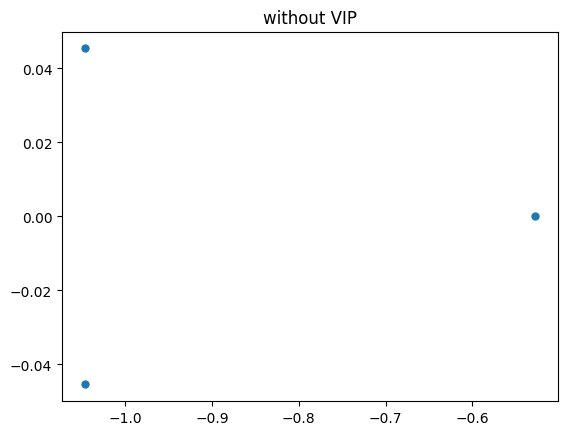

In [148]:

J = get_jacobian(W, 3)
eigvals, eigvecs = np.linalg.eig(J)
plt.plot(np.real(eigvals), np.imag(eigvals), 'o', markersize=5)
plt.title('without VIP')

# sample ISNs

In [7]:
#extract mean activity per cell type
som = data['sst']
som_act = np.mean(som, axis =0)

pv = data['pv']
pv_act = np.mean(pv, axis =0)

vip = data['vip']
vip_act = np.mean(vip, axis =0)

e = data['pyr']
e_act = np.mean(e, axis =0)

mean_rates = (e_act, pv_act, som_act, vip_act)
std_rates = (np.std(e, axis =0), np.std(pv, axis =0), np.std(som, axis =0), np.std(vip, axis =0))


In [8]:
mean_rates = (e_act, pv_act, som_act, vip_act)
mean_rates


(array([0.21634893, 0.22840137, 0.28256743, 0.3946991 , 0.51465092,
        0.59149586]),
 array([0.20270902, 0.24957409, 0.2955943 , 0.4072691 , 0.5950653 ,
        0.73559046]),
 array([0.10236657, 0.12339172, 0.1086949 , 0.15047143, 0.26108373,
        0.55200543]),
 array([0.39859679, 0.50254461, 0.57907857, 0.63834552, 0.48090594,
        0.40052857]))

In [9]:
#sample rates based on mean and var from gaussian model
import torch
isn_count = 0
n = 400
W = []
h = []
while (isn_count <n):

    e_act = np.random.normal(mean_rates[0], std_rates[0])
    while (e_act < 0).any():
        e_act = np.random.normal(mean_rates[0], std_rates[0])
    pv_act = np.random.normal(mean_rates[1], std_rates[1])
    while (pv_act < 0).any():    
        pv_act = np.random.normal(mean_rates[1], std_rates[1])
    som_act = np.random.normal(mean_rates[2], std_rates[2])
    while (som_act < 0).any():
        som_act = np.random.normal(mean_rates[2], std_rates[2])
    vip_act = np.random.normal(mean_rates[3], std_rates[3])
    while (vip_act < 0).any():
        vip_act = np.random.normal(mean_rates[3], std_rates[3])
  
    #fit som
    # we use negative values to indicate inhibition (and then use non negative least squares)
    A = np.concatenate((e_act[:,np.newaxis], -1*pv_act[:,np.newaxis], -1*som_act[:,np.newaxis], -1*vip_act[:,np.newaxis]), axis = 1)
    A = np.concatenate((A, np.zeros((A.shape[0],1))), axis = 1)
    A = np.concatenate((A, np.ones((A.shape[0],1))), axis = 1)

    y = power_law_inv(som_act)
    x_som = nnls(A, y)
    e_som = x_som[1]

    #fit vip
    y = power_law_inv(vip_act)
    x_vip = nnls(A, y)
    e_vip = x_vip[1]

    #fit pv
    A = np.concatenate((e_act[:,np.newaxis], -1* pv_act[:,np.newaxis], -1*som_act[:,np.newaxis], -1*vip_act[:,np.newaxis]), axis = 1)
    Is = data['contrast']/100
    A = np.concatenate((A, Is.T), axis=1) 
    A = np.concatenate((A, np.ones((A.shape[0],1))), axis = 1)
    y = power_law_inv(pv_act,)
    x_pv = nnls(A, y)
    e_pv = x_pv[1]

    #fit e
    y = power_law_inv(e_act)
    x_e = nnls(A, y)
    e_e = x_e[1]

    error = e_e + e_pv + e_som + e_vip
    
    def get_rates(W):
        i=0
        max_it = 5000
        wb = W.flatten()

        delta_t = 0.1
        tau = torch.tensor([1.0, 1.0, 1.0, 1.0]) 

        r = torch.rand(4)  # Initialize r with shape (4, 6)
        I_values =data['contrast'][0][0]/torch.tensor([100])# Get the 6 different I values
        rs = []

        while i < max_it:
        
            A_1 = torch.tensor([r[0], -1 * r[1], -1 *r[2], -1 * r[3], I_values, 1])
            A_2 = torch.tensor([r[0], -1 * r[1], -1* r[2], -1 * r[3], 0, 1])
            
            r_delta = -r + power_law_nl(torch.tensor([A_1 @ wb[0:6], A_1 @ wb[6:12], A_2 @ wb[12:18], A_2 @ wb[18:24]])) 
            r = r+ delta_t * r_delta/tau
            rs.append(r.numpy())
            
            eps = torch.sum(torch.pow(r_delta, 2))
            if torch.isnan(eps) or torch.isinf(eps):
                return torch.nan
            elif eps < 1e-6:
                break
            
            i += 1
        if i == max_it:
            return torch.nan
        return r[0]
    criterium = 1-2*get_rates(torch.tensor([x_e[0], x_pv[0], x_som[0], x_vip[0]], dtype=torch.float32))*x_e[0][0]
    if criterium <0:
        isn_count +=1
        print(isn_count)
        W.append((np.array([x_e[0][:4], x_pv[0][:4], x_som[0][:4], x_vip[0][:4]]),error))
        h.append((np.array([x_e[0][4:], x_pv[0][4:], x_som[0][4:], x_vip[0][4:]]),error))


C:\Users\linau\AppData\Local\Temp\ipykernel_51056\1681760353.py:84: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:277.)
  criterium = 1-2*get_rates(torch.tensor([x_e[0], x_pv[0], x_som[0], x_vip[0]], dtype=torch.float32))*x_e[0][0]


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260


KeyboardInterrupt: 

In [180]:

#choose 200 models with lowest error and compute mean W and h
n_best  = 8
W_best = sorted(W, key = lambda x: x[1])[:n_best]
W_best_mean = np.mean([w[0] for w in W_best], axis = 0)
h_best = sorted(h, key = lambda x: x[1])[:n_best]
h_best_mean = np.mean([w[0] for w in h_best], axis = 0)

In [138]:
n_best  = 8
W_best = sorted(W, key = lambda x: x[1])[:n_best]
W_best_mean = np.median([w[0] for w in W_best], axis = 0)
h_best = sorted(h, key = lambda x: x[1])[:n_best]
h_best_mean = np.median([w[0] for w in h_best], axis = 0)

In [181]:
def Wh_to_wb(W,h):
    W_all = np.concatenate((W,h), axis = 1)
    return W_all.flatten()
  
  

wb = Wh_to_wb(W_best_mean,h_best_mean)

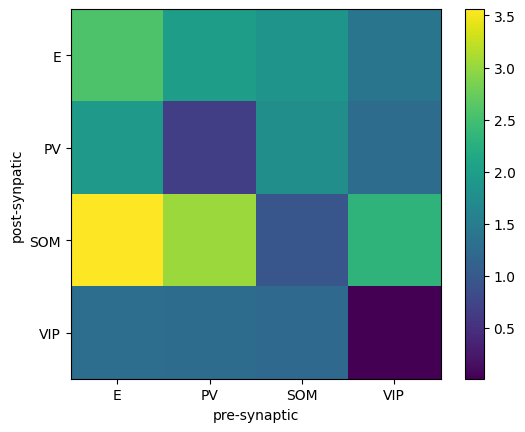

In [182]:
cells = ['E','PV', 'SOM', 'VIP']

import matplotlib.pyplot as plt
plt.imshow(W_best_mean)
plt.ylabel('post-synpatic')
plt.xlabel('pre-synaptic')
plt.xticks(np.arange(4), cells)
plt.yticks(np.arange(4), cells)
plt.colorbar()

In [183]:
#test simulator
import torch
i=0
max_it = 5000
wb = Wh_to_wb(W_best_mean,h_best_mean)

# wb[1,:] = torch.tensor([0,0,0,0,0,0])
# wb[0,1] = 0
# wb[2,1] = 0
# wb[3,1] = 0
wb = wb.flatten()

delta_t = 0.1
tau = torch.tensor([1.0, 1.0, 1.0, 1.0]) 



r = torch.rand(4)  # Initialize r with shape (4, 6)
I_values =data['contrast'][0][0]/torch.tensor([100])# Get the 6 different I values
rs = []

while i < max_it:
    
  
    A_1 = torch.tensor([r[0], -1 * r[1], -1 *r[2], -1 * r[3], I_values, 1])
    A_2 = torch.tensor([r[0], -1 * r[1], -1* r[2], -1 * r[3], 0, 1])
    
    r_delta = -r + power_law_nl(torch.tensor([A_1 @ wb[0:6], A_1 @ wb[6:12], A_2 @ wb[12:18], A_2 @ wb[18:24]])) 
    r = r+ delta_t * r_delta/tau
    rs.append(r.numpy())
    
    eps = torch.sum(torch.pow(r_delta, 2))
    if eps < 1e-6 or torch.isnan(eps):
        break
    
    i += 1

print(r,i)

tensor([6.6728e-04, 3.0553e-02, 7.3375e-01, 4.7450e-03], dtype=torch.float64) 77


In [184]:
def get_jacobian(W, idx):
    W = np.delete(W, idx, 1)
    W = np.delete(W, idx, 0)
    phi_prime = np.diag(2 *np.delete(r,idx))
    print(W)
    J = (-np.eye(len(W))+ phi_prime @ W)/np.delete(tau,idx)
    return J

[[0.67742393 1.76221223 1.26937943]
 [3.02982436 0.95781227 2.31788754]
 [1.27076719 1.22447505 0.01379608]]


Text(0.5, 1.0, 'without E')

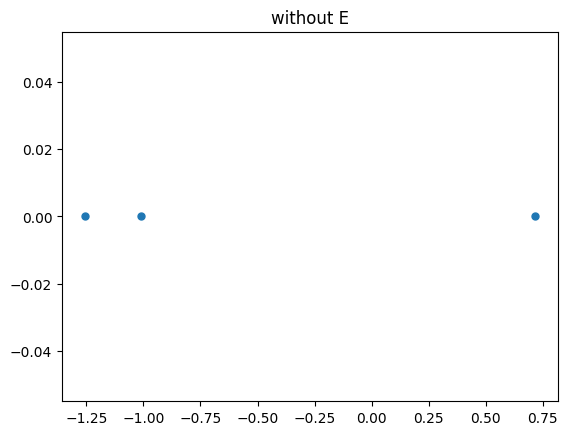

In [185]:
#no e

J = get_jacobian(W_best_mean, 0)
eigvals, eigvecs = np.linalg.eig(J)
plt.plot(np.real(eigvals), np.imag(eigvals), 'o', markersize=5)
plt.title('without E')


[[2.56544898 1.85230063 1.38646334]
 [3.5610332  0.95781227 2.31788754]
 [1.30003013 1.22447505 0.01379608]]


Text(0.5, 1.0, 'without PV')

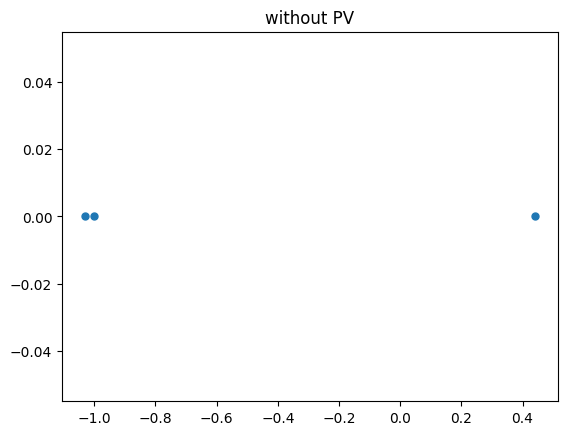

In [186]:
#no pv

J = get_jacobian(W_best_mean, 1)
eigvals, eigvecs = np.linalg.eig(J)
plt.plot(np.real(eigvals), np.imag(eigvals), 'o', markersize=5)
plt.title('without PV')

[[2.56544898 1.98992342 1.38646334]
 [1.93632215 0.67742393 1.26937943]
 [1.30003013 1.27076719 0.01379608]]


Text(0.5, 1.0, 'without SOM')

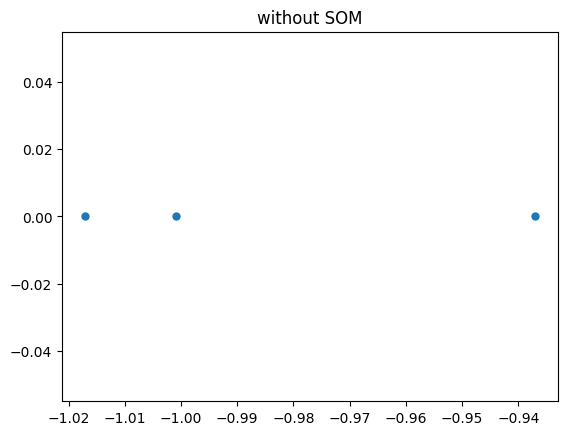

In [187]:

J = get_jacobian(W_best_mean, 2)
eigvals, eigvecs = np.linalg.eig(J)
plt.plot(np.real(eigvals), np.imag(eigvals), 'o', markersize=5)
plt.title('without SOM')

[[2.56544898 1.98992342 1.38646334]
 [1.93632215 0.67742393 1.26937943]
 [1.30003013 1.27076719 0.01379608]]


Text(0.5, 1.0, 'without VIP')

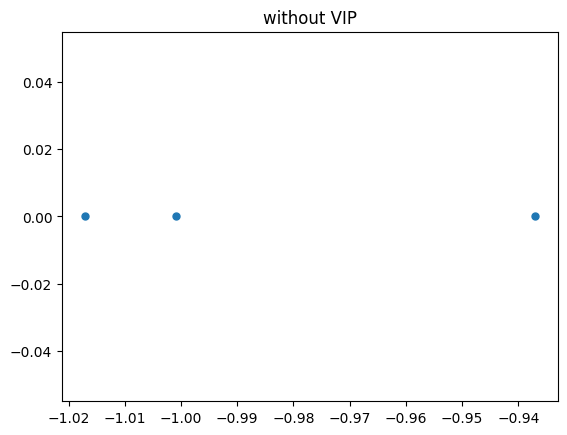

In [188]:

J = get_jacobian(W_best_mean, 2)
eigvals, eigvecs = np.linalg.eig(J)
plt.plot(np.real(eigvals), np.imag(eigvals), 'o', markersize=5)
plt.title('without VIP')